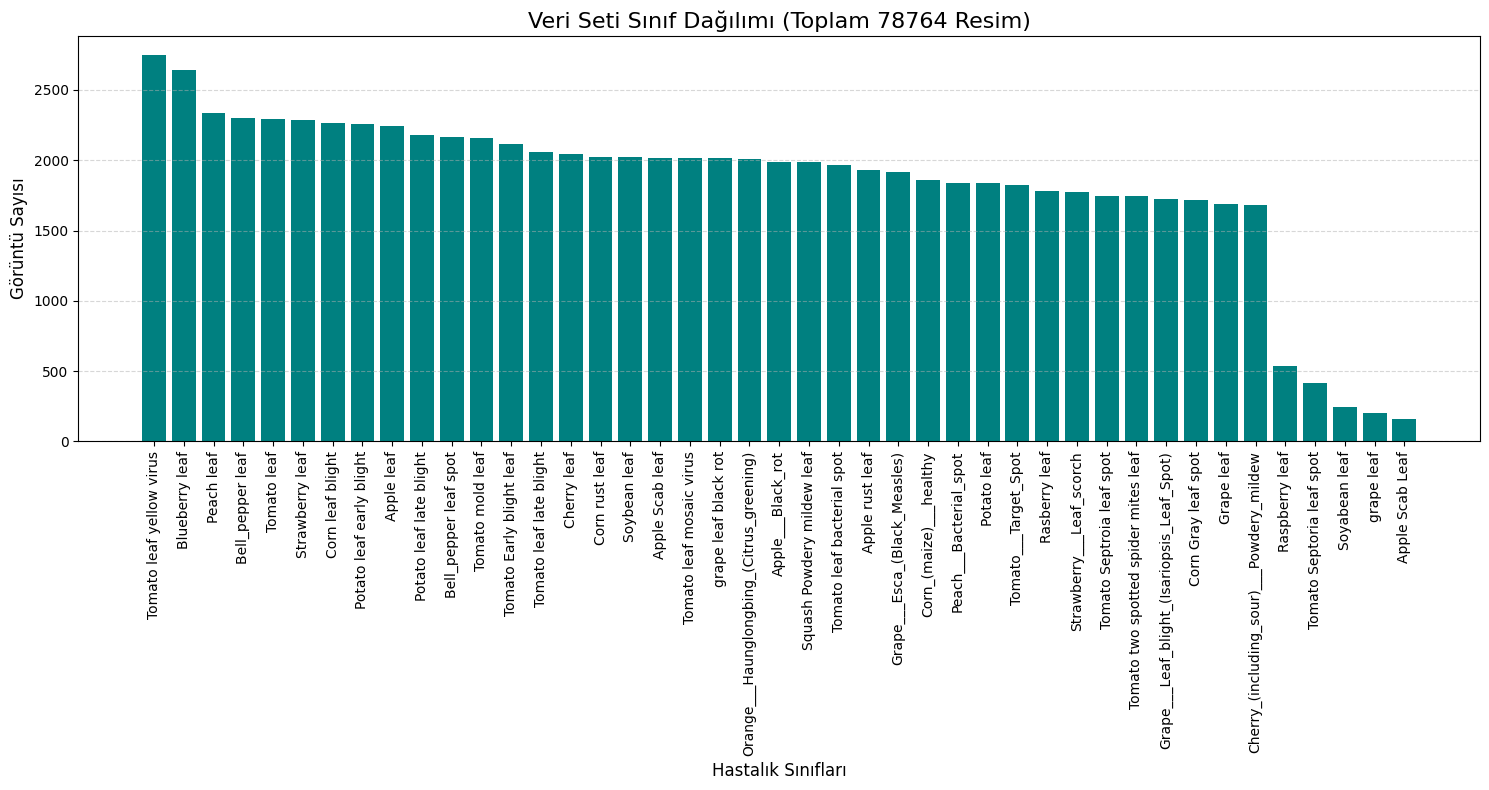

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'

df = pd.read_csv(VERI_DOSYASI)

sinif_sayilari = df['class'].value_counts()

plt.figure(figsize=(15, 8))
plt.bar(sinif_sayilari.index, sinif_sayilari.values, color='teal')


plt.xticks(rotation=90) 
plt.title(f"Veri Seti Sınıf Dağılımı (Toplam {len(df)} Resim)", fontsize=16)
plt.xlabel("Hastalık Sınıfları", fontsize=12)
plt.ylabel("Görüntü Sayısı", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models  # models eklendi
from PIL import Image
import random
from sklearn.metrics import f1_score
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
BATCH_SIZE = 16 
LEARNING_RATE = 0.001
EPOCHS = 15
RESIM_BOYUTU = 128 # Not: Inception_v3 normalde 299x299 sever ama 128 ile de çalışır.

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    print("Veriler Hazırlanıyor...")
    dataset = TankVeriSeti(csv_file=VERI_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")
    
    # Inception V3 modelini yüklüyoruz.
    # aux_logits=False yapmazsak kod patlar (tuple hatası verir).
    print("Inception V3 modeli yükleniyor...")
    model = models.inception_v3(weights=None, aux_logits=False, init_weights=True) 
    
    # Son katmanı veri setindeki sınıf sayısına göre değiştiriyoruz
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(dataset.sinif_isimleri))
    
    model = model.to(device)
    # -------------------------

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nEĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)")
    print("-" * 60)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 50 == 0:
                print(f"Epoch [{epoch+1}] | Adım [{i+1}/{len(train_loader)}] | Anlık Loss: {loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1} Bitti ({elapsed_time:.1f} sn) | Train Acc: %{train_acc:.2f} | Loss: {avg_train_loss:.4f}")
        print("Doğrulama (Validation) yapılıyor...")
        
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        print(f"VAL ACC: %{val_acc:.2f}")
        print("-" * 60)

    torch.save(model.state_dict(), 'model_final_inception.pth')
    print("Model Kaydedildi.")

✅ Kullanılan Cihaz: cuda
Veriler Hazırlanıyor...
Train: 63011 | Val: 15753
Inception V3 modeli yükleniyor...

EĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)
------------------------------------------------------------
Epoch [1] | Adım [50/3939] | Anlık Loss: 4.0834
Epoch [1] | Adım [100/3939] | Anlık Loss: 3.4856
Epoch [1] | Adım [150/3939] | Anlık Loss: 2.3577
Epoch [1] | Adım [200/3939] | Anlık Loss: 2.7302
Epoch [1] | Adım [250/3939] | Anlık Loss: 2.6064
Epoch [1] | Adım [300/3939] | Anlık Loss: 3.0354
Epoch [1] | Adım [350/3939] | Anlık Loss: 2.6382
Epoch [1] | Adım [400/3939] | Anlık Loss: 2.4236
Epoch [1] | Adım [450/3939] | Anlık Loss: 2.5129
Epoch [1] | Adım [500/3939] | Anlık Loss: 2.2669
Epoch [1] | Adım [550/3939] | Anlık Loss: 2.5466
Epoch [1] | Adım [600/3939] | Anlık Loss: 1.9762
Epoch [1] | Adım [650/3939] | Anlık Loss: 3.1410
Epoch [1] | Adım [700/3939] | Anlık Loss: 2.7340
Epoch [1] | Adım [750/3939] | Anlık Loss: 1.9297
Epoch [1] | Adım [800/3939] | Anlık Loss: 

In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models # models eklendi
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

CSV_DOSYASI = VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
MODEL_PATH = "model_final_inception.pth" 
BATCH_SIZE = 16 
RESIM_BOYUTU = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)


if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    
    num_classes = len(dataset.sinif_isimleri)
    
    model = models.inception_v3(weights=None, aux_logits=False, init_weights=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    # ---------------------------------------------------

    if os.path.exists(MODEL_PATH):
        print(f"Model yükleniyor: {MODEL_PATH}")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'),weights_only=True))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}...")

    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print("\n" + "="*50)
    print("MODEL PERFORMANS RAPORU")
    print("="*50)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
    print("-" * 50)
    
    print("\nHASTALIK BAZLI DETAYLI RAPOR:")
    print(classification_report(all_labels, all_preds, target_names=dataset.sinif_isimleri, labels=range(len(dataset.sinif_isimleri)),zero_division=0))

✅ Kullanılan Cihaz: cuda
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
Model yükleniyor: model_final_inception.pth

TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50...
   İşlenen paket: 100...
   İşlenen paket: 150...
   İşlenen paket: 200...
   İşlenen paket: 250...
   İşlenen paket: 300...
   İşlenen paket: 350...
   İşlenen paket: 400...
   İşlenen paket: 450...
   İşlenen paket: 500...
   İşlenen paket: 550...
   İşlenen paket: 600...
   İşlenen paket: 650...
   İşlenen paket: 700...
   İşlenen paket: 750...
   İşlenen paket: 800...
   İşlenen paket: 850...
   İşlenen paket: 900...
   İşlenen paket: 950...

MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %98.73
Genel F1 Skoru (Weighted): 0.9872
Genel F1 Skoru (Macro)   : 0.9782
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR:
                                            precision    recall  f1-score   support

                           Apple Scab Leaf       0.91      0.

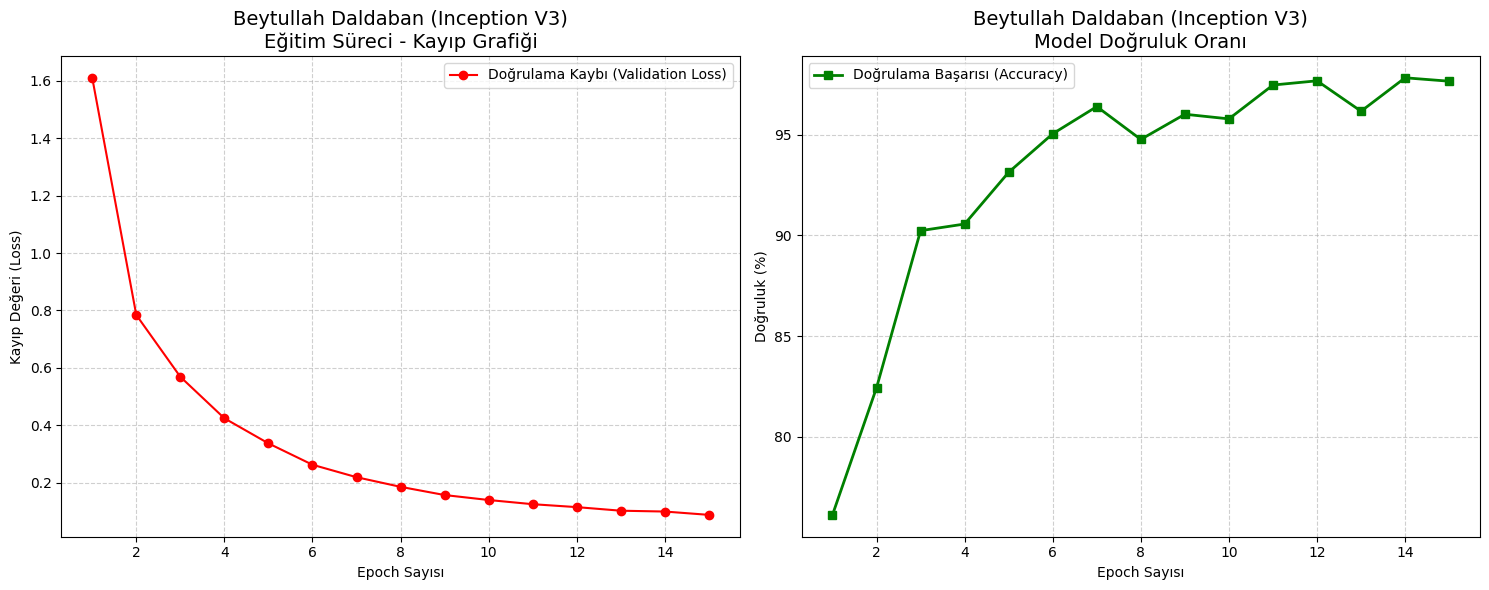

In [1]:
import matplotlib.pyplot as plt

USER_INFO = "Beytullah Daldaban (Inception V3)"

epochs = list(range(1, 16))

val_losses = [1.6110, 0.7842, 0.5686, 0.4240, 0.3365, 0.2620, 0.2186, 0.1850, 0.1564, 0.1391, 0.1245, 0.1143, 0.1018, 0.0989, 0.0873 ] 

accuracies = [76.13, 82.44, 90.24, 90.57, 93.14, 95.05, 96.40, 94.77, 96.02, 95.79, 97.47, 97.68, 96.17, 97.83, 97.66 ]
# --------------------------------

if not val_losses or not accuracies:
    print("Lütfen 'val_losses' ve 'accuracies' listelerinin içini doldur!")
    exit()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation Loss)')
plt.title(f'{USER_INFO}\nEğitim Süreci - Kayıp Grafiği', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')
plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models # models eklendi
from PIL import Image
import random
from sklearn.metrics import f1_score
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
BATCH_SIZE = 16 
LEARNING_RATE = 0.001
EPOCHS = 15
RESIM_BOYUTU = 128

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    print("Veriler Hazırlanıyor...")
    dataset = TankVeriSeti(csv_file=VERI_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")
    
    print("ResNeXt-50 (32x4d) modeli yükleniyor...")
    # weights=None diyerek sıfırdan eğitim başlatıyoruz.
    model = models.resnext50_32x4d(weights=None)
    
    # Son katmanı (fc) sınıf sayısına göre değiştiriyoruz
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(dataset.sinif_isimleri))
    
    model = model.to(device)
    # -------------------------------------------------

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nEĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)")
    print("-" * 60)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 50 == 0:
                print(f"Epoch [{epoch+1}] | Adım [{i+1}/{len(train_loader)}] | Anlık Loss: {loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1} Bitti ({elapsed_time:.1f} sn) | Train Acc: %{train_acc:.2f} | Loss: {avg_train_loss:.4f}")
        print("Doğrulama (Validation) yapılıyor...")
        
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        print(f"VAL ACC: %{val_acc:.2f}")
        print("-" * 60)

    torch.save(model.state_dict(), 'model_final_resnext50.pth')
    print("Model Kaydedildi.")

✅ Kullanılan Cihaz: cuda
Veriler Hazırlanıyor...
Train: 63011 | Val: 15753
ResNeXt-50 (32x4d) modeli yükleniyor...

EĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)
------------------------------------------------------------
Epoch [1] | Adım [50/3939] | Anlık Loss: 4.6825
Epoch [1] | Adım [100/3939] | Anlık Loss: 3.0377
Epoch [1] | Adım [150/3939] | Anlık Loss: 2.7928
Epoch [1] | Adım [200/3939] | Anlık Loss: 2.7710
Epoch [1] | Adım [250/3939] | Anlık Loss: 2.4318
Epoch [1] | Adım [300/3939] | Anlık Loss: 3.3850
Epoch [1] | Adım [350/3939] | Anlık Loss: 2.2268
Epoch [1] | Adım [400/3939] | Anlık Loss: 2.6287
Epoch [1] | Adım [450/3939] | Anlık Loss: 2.5133
Epoch [1] | Adım [500/3939] | Anlık Loss: 2.2517
Epoch [1] | Adım [550/3939] | Anlık Loss: 2.9279
Epoch [1] | Adım [600/3939] | Anlık Loss: 2.6664
Epoch [1] | Adım [650/3939] | Anlık Loss: 2.3148
Epoch [1] | Adım [700/3939] | Anlık Loss: 1.8280
Epoch [1] | Adım [750/3939] | Anlık Loss: 2.5469
Epoch [1] | Adım [800/3939] | Anlık 

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models 
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report

VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
MODEL_PATH = "model_final_resnext50.pth" 
BATCH_SIZE = 16 
RESIM_BOYUTU = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)


if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = TankVeriSeti(csv_file=VERI_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    
    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    
    num_classes = len(dataset.sinif_isimleri)
    
    print("ResNeXt-50 modeli yükleniyor...")
    model = models.resnext50_32x4d(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    # -------------------------------------------------

    if os.path.exists(MODEL_PATH):
        print(f"Model yükleniyor: {MODEL_PATH}")
        # Hata vermemesi için weights_only=True ve map_location parametrelerini ekledim
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # CUDA hatası vermemesi için .cpu() ekledim
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}...")

    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print("\n" + "="*50)
    print("MODEL PERFORMANS RAPORU")
    print("="*50)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
    print("-" * 50)
    
    print("\nHASTALIK BAZLI DETAYLI RAPOR:")
    
    # Rapor hatası vermemesi için labels ve zero_division ekledim
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=dataset.sinif_isimleri, 
        labels=range(len(dataset.sinif_isimleri)),
        zero_division=0
    ))

✅ Kullanılan Cihaz: cuda
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
ResNeXt-50 modeli yükleniyor...
Model yükleniyor: model_final_resnext50.pth

TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50...
   İşlenen paket: 100...
   İşlenen paket: 150...
   İşlenen paket: 200...
   İşlenen paket: 250...
   İşlenen paket: 300...
   İşlenen paket: 350...
   İşlenen paket: 400...
   İşlenen paket: 450...
   İşlenen paket: 500...
   İşlenen paket: 550...
   İşlenen paket: 600...
   İşlenen paket: 650...
   İşlenen paket: 700...
   İşlenen paket: 750...
   İşlenen paket: 800...
   İşlenen paket: 850...
   İşlenen paket: 900...
   İşlenen paket: 950...

MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %99.04
Genel F1 Skoru (Weighted): 0.9904
Genel F1 Skoru (Macro)   : 0.9895
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR:
                                            precision    recall  f1-score   support

                           Ap

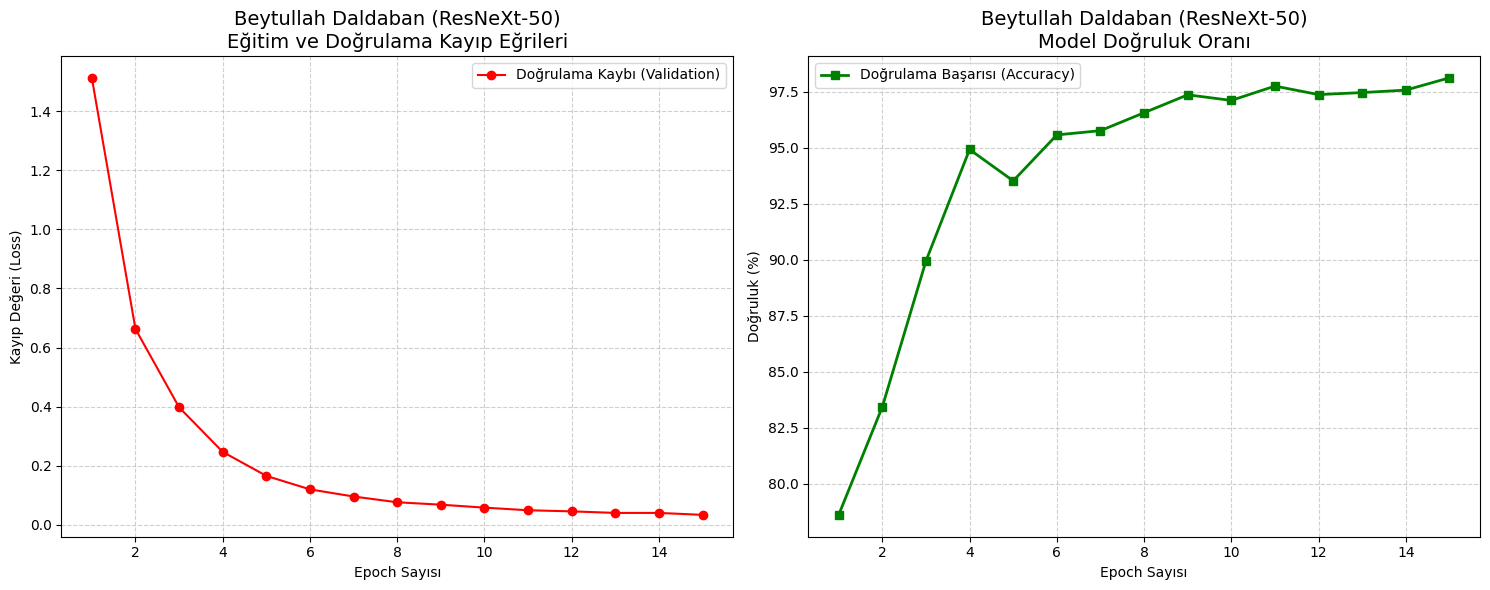

In [2]:
import matplotlib.pyplot as plt


USER_INFO = "Beytullah Daldaban (ResNeXt-50)"

epochs = list(range(1, 16))

val_losses = [1.5139, 0.6628, 0.3974, 0.2463, 0.1650, 0.1193, 0.0951, 0.0756, 0.0674, 0.0574, 0.0485, 0.0448, 0.0395, 0.0395, 0.0329] 

accuracies = [78.62, 83.44, 89.95, 94.93, 93.53, 95.58, 95.77, 96.57, 97.37, 97.12, 97.76, 97.38, 97.47, 97.58, 98.13]
# -----------------------------------------------

if not val_losses or not accuracies:
    print("Lütfen 'val_losses' ve 'accuracies' listelerinin içini doldur kanka!")
    exit()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation)')

plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')

plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

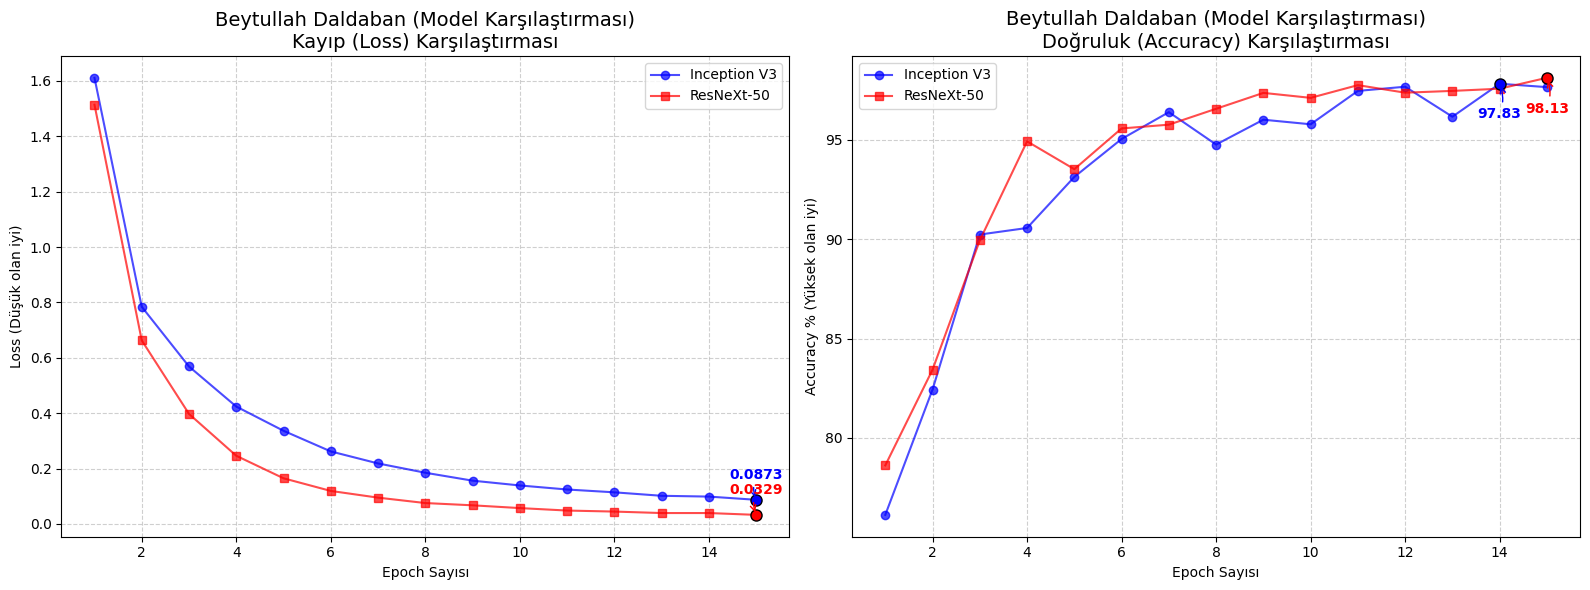

In [6]:
import matplotlib.pyplot as plt
import numpy as np

USER_INFO = "Beytullah Daldaban (Model Karşılaştırması)"
epochs = list(range(1, 16))

inception_loss = [1.6110, 0.7842, 0.5686, 0.4240, 0.3365, 0.2620, 0.2186, 0.1850, 0.1564, 0.1391, 0.1245, 0.1143, 0.1018, 0.0989, 0.0873] 
inception_acc  = [76.13, 82.44, 90.24, 90.57, 93.14, 95.05, 96.40, 94.77, 96.02, 95.79, 97.47, 97.68, 96.17, 97.83, 97.66] 

resnext_loss = [1.5139, 0.6628, 0.3974, 0.2463, 0.1650, 0.1193, 0.0951, 0.0756, 0.0674, 0.0574, 0.0485, 0.0448, 0.0395, 0.0395, 0.0329]
resnext_acc  = [78.62, 83.44, 89.95, 94.93, 93.53, 95.58, 95.77, 96.57, 97.37, 97.12, 97.76, 97.38, 97.47, 97.58, 98.13]


if not (inception_loss and inception_acc and resnext_loss and resnext_acc):
    print("Lütfen tüm loss ve accuracy listelerini doldur!")
    exit()

def isaretle(x, y, tip='min', renk='black'):
    """Grafik üzerine en iyi değeri ok ile yazar"""
    if tip == 'min':
        target_val = min(y)
        idx = y.index(target_val)
        text_prefix = "Min"
        xy_text_offset = (0, 15) # Metni biraz yukarı koy
    else: # max
        target_val = max(y)
        idx = y.index(target_val)
        text_prefix = "Max"
        xy_text_offset = (0, -25) # Metni biraz aşağı koy

    target_epoch = x[idx]
    
    plt.annotate(f'{target_val}', 
                 xy=(target_epoch, target_val), 
                 xytext=xy_text_offset,
                 textcoords='offset points',
                 ha='center',
                 color=renk,
                 fontweight='bold',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color=renk))
    
    # Noktayı belirginleştirmek için üzerine bir scatter koyar
    plt.plot(target_epoch, target_val, marker='o', markersize=8, markeredgecolor='black', markerfacecolor=renk)


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, inception_loss, 'b-o', label='Inception V3', alpha=0.7)
plt.plot(epochs, resnext_loss, 'r-s', label='ResNeXt-50', alpha=0.7)

# En düşük Loss değerlerini işaretle
isaretle(epochs, inception_loss, tip='min', renk='blue')
isaretle(epochs, resnext_loss, tip='min', renk='red')

plt.title(f'{USER_INFO}\nKayıp (Loss) Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Loss (Düşük olan iyi)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, inception_acc, 'b-o', label='Inception V3', alpha=0.7)
plt.plot(epochs, resnext_acc, 'r-s', label='ResNeXt-50', alpha=0.7)

# En yüksek Accuracy değerlerini işaretle
isaretle(epochs, inception_acc, tip='max', renk='blue')
isaretle(epochs, resnext_acc, tip='max', renk='red')

plt.title(f'{USER_INFO}\nDoğruluk (Accuracy) Karşılaştırması', fontsize=14)
plt.xlabel('Epoch Sayısı')
plt.ylabel('Accuracy % (Yüksek olan iyi)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
from IPython.display import display

inception_acc_list = [76.13, 82.44, 90.24, 90.57, 93.14, 95.05, 96.40, 94.77, 96.02, 95.79, 97.47, 97.68, 96.17, 97.83, 97.66]
inception_loss_list = [1.6110, 0.7842, 0.5686, 0.4240, 0.3365, 0.2620, 0.2186, 0.1850, 0.1564, 0.1391, 0.1245, 0.1143, 0.1018, 0.0989, 0.0873]

resnext_acc_list = [78.62, 83.44, 89.95, 94.93, 93.53, 95.58, 95.77, 96.57, 97.37, 97.12, 97.76, 97.38, 97.47, 97.58, 98.13]
resnext_loss_list = [1.5139, 0.6628, 0.3974, 0.2463, 0.1650, 0.1193, 0.0951, 0.0756, 0.0674, 0.0574, 0.0485, 0.0448, 0.0395, 0.0395, 0.0329]

# --- HESAPLAMA ---
inc_best_acc = max(inception_acc_list)
inc_min_loss = min(inception_loss_list)

res_best_acc = max(resnext_acc_list)
res_min_loss = min(resnext_loss_list)

# --- TABLO OLUŞTURMA ---
results = {
    "Model İsmi": ["Inception V3", "ResNeXt-50"],
    "En Yüksek Başarı (%)": [f"%{inc_best_acc:.2f}", f"%{res_best_acc:.2f}"],
    "En Düşük Kayıp (Loss)": [f"{inc_min_loss:.4f}", f"{res_min_loss:.4f}"]
}

df_results = pd.DataFrame(results)

print("\n" + "="*45)
print("🏆 MODEL KARŞILAŞTIRMA TABLOSU (FİNAL) 🏆")
print("="*45)

display(df_results) 


🏆 MODEL KARŞILAŞTIRMA TABLOSU (FİNAL) 🏆


Model İsmi En Yüksek Başarı (%) En Düşük Kayıp (Loss)
0  Inception V3               %97.83                0.0873
1    ResNeXt-50               %98.13                0.0329

Yüksek çözünürlüklü karşılaştırma yapılıyor 


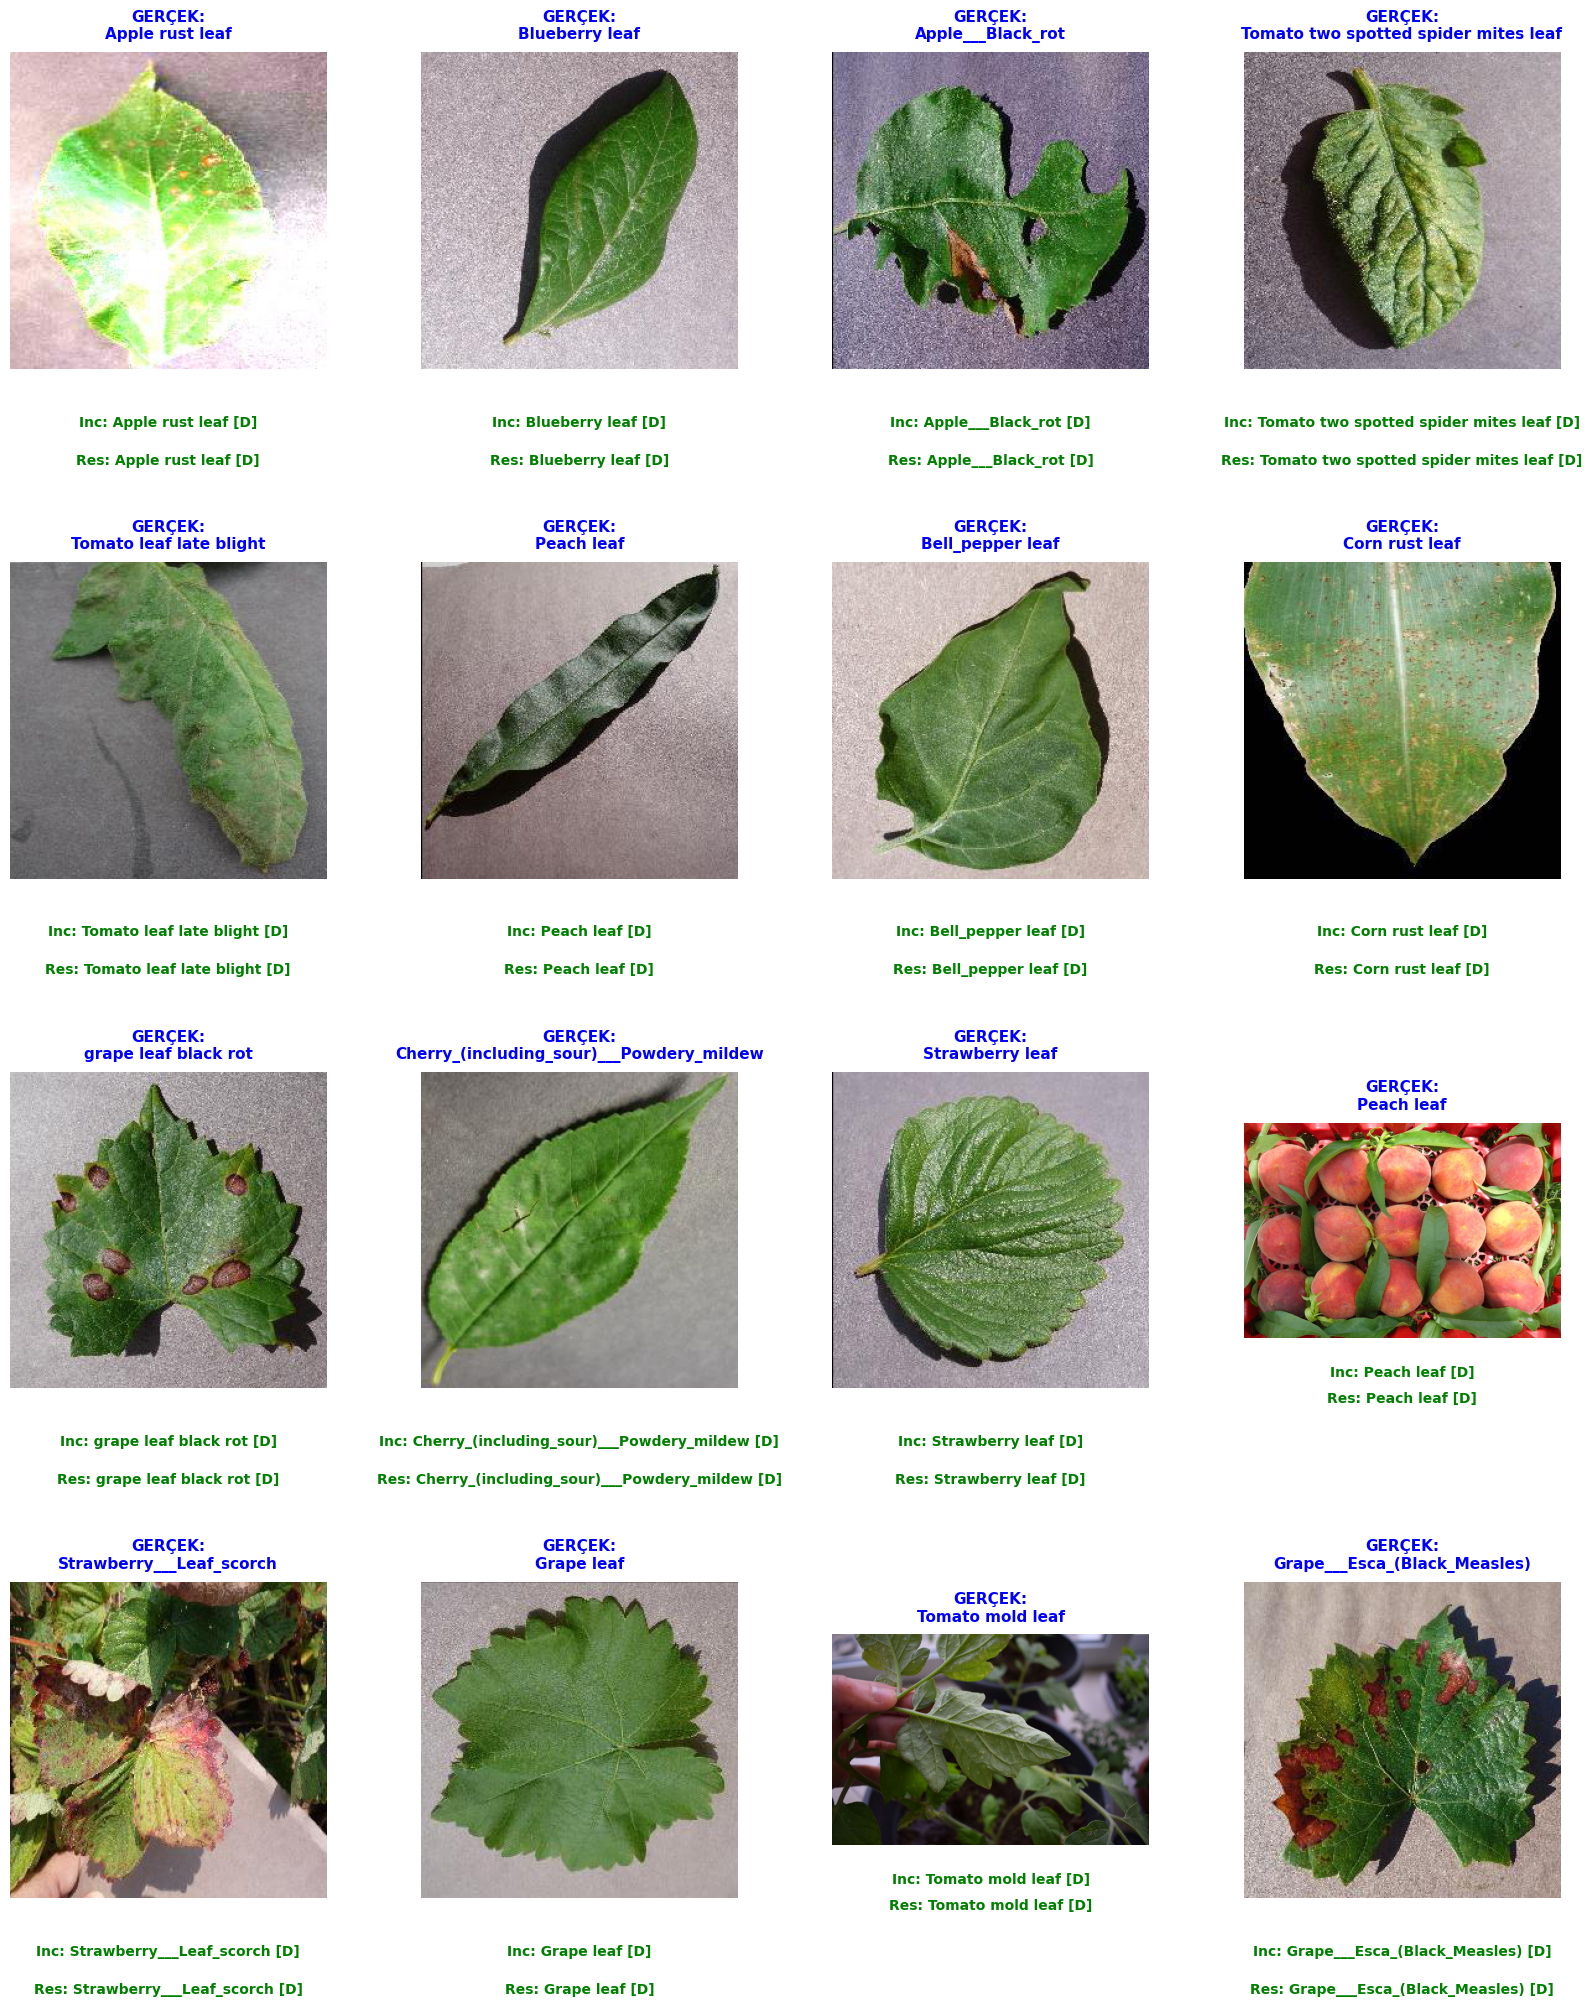

In [25]:
def hd_karsilastirma(model1, model2, dataset, sinif_isimleri):
    # Rastgele 16 tane indeks seçelim
    indices = random.sample(range(len(dataset)), 16)
    
    # Modelin anlayacağı transform (Küçültme + Normalize)
    model_transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Çizim Alanı
    fig = plt.figure(figsize=(20, 24), dpi=100)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    for i, idx in enumerate(indices):
        img_path, label_idx = dataset.get_image_info(idx)
        
        while img_path is None:
            idx = random.randint(0, len(dataset)-1)
            img_path, label_idx = dataset.get_image_info(idx)

        # 2. Resmi İKİ KERE açıyoruz
        img_display = Image.open(img_path).convert("RGB")
        img_tensor = model_transform(img_display).unsqueeze(0).to(device)
        
        # --- TAHMİNLER ---
        with torch.no_grad():
            out1 = model1(img_tensor)
            _, pred1 = torch.max(out1, 1)
            
        with torch.no_grad():
            out2 = model2(img_tensor)
            _, pred2 = torch.max(out2, 1)

        # --- ÇİZİM ---
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img_display)
        
        label_gercek = sinif_isimleri[label_idx]
        label_p1 = sinif_isimleri[pred1.item()]
        label_p2 = sinif_isimleri[pred2.item()]
        
        
        renk1 = 'green' if pred1.item() == label_idx else 'red'
        mark1 = '[D]' if pred1.item() == label_idx else '[Y]'
        
        renk2 = 'green' if pred2.item() == label_idx else 'red'
        mark2 = '[D]' if pred2.item() == label_idx else '[Y]'

        ax.set_title(f"GERÇEK:\n{label_gercek}", fontsize=11, color='blue', fontweight='bold', pad=10)
        
        # Inception Sonucu
        ax.text(0.5, -0.18, f"Inc: {label_p1} {mark1}", 
                transform=ax.transAxes, ha='center', color=renk1, fontweight='bold', fontsize=10)
        
        # ResNeXt Sonucu
        ax.text(0.5, -0.30, f"Res: {label_p2} {mark2}", 
                transform=ax.transAxes, ha='center', color=renk2, fontweight='bold', fontsize=10)
        
        plt.axis('off')
        
    plt.show()

if __name__ == '__main__':
    if inception_model and resnext_model:
        print("Yüksek çözünürlüklü karşılaştırma yapılıyor ")
        hd_karsilastirma(inception_model, resnext_model, dataset, dataset.sinif_isimleri)